In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

df = pd.read_csv('Dataset.csv')

# 划分特征和目标变量
X = df.drop(['target'], axis=1)
y = df['target']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=df['target'])

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,1,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,2,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,0,0


In [2]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# XGBoost模型参数
params_xgb = {
    'learning_rate': 0.02,            # 学习率，控制每一步的步长，用于防止过拟合。典型值范围：0.01 - 0.1
    'booster': 'gbtree',              # 提升方法，这里使用梯度提升树（Gradient Boosting Tree）
    'objective': 'binary:logistic',   # 损失函数，这里使用逻辑回归，用于二分类任务
    'max_leaves': 127,                # 每棵树的叶子节点数量，控制模型复杂度。较大值可以提高模型复杂度但可能导致过拟合
    'verbosity': 1,                   # 控制 XGBoost 输出信息的详细程度，0表示无输出，1表示输出进度信息
    'seed': 42,                       # 随机种子，用于重现模型的结果
    'nthread': -1,                    # 并行运算的线程数量，-1表示使用所有可用的CPU核心
    'colsample_bytree': 0.6,          # 每棵树随机选择的特征比例，用于增加模型的泛化能力
    'subsample': 0.7,                 # 每次迭代时随机选择的样本比例，用于增加模型的泛化能力
    'eval_metric': 'logloss'          # 评价指标，这里使用对数损失（logloss）
}


# 初始化XGBoost分类模型
model_xgb = xgb.XGBClassifier(**params_xgb)


# 定义参数网格，用于网格搜索
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # 树的数量
    'max_depth': [3, 4, 5, 6, 7],               # 树的深度
    'learning_rate': [0.01, 0.02, 0.05, 0.1],   # 学习率
}


# 使用GridSearchCV进行网格搜索和k折交叉验证
grid_search = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid,
    scoring='neg_log_loss',  # 评价指标为负对数损失
    cv=5,                    # 5折交叉验证
    n_jobs=-1,               # 并行计算
    verbose=1                # 输出详细进度信息
)

# 训练模型
grid_search.fit(X_train, y_train)

# 输出最优参数
print("Best parameters found: ", grid_search.best_params_)
print("Best Log Loss score: ", -grid_search.best_score_)

# 使用最优参数训练模型
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 400}
Best Log Loss score:  0.40901020403803195


In [3]:
import joblib
# 保存模型
joblib.dump(best_model , 'XGBoost.pkl')

['XGBoost.pkl']

In [4]:
from sklearn.metrics import classification_report

# 预测测试集
y_pred = best_model.predict(X_test)

# 输出模型报告， 查看评价指标
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88        32
           1       0.88      0.82      0.85        28

    accuracy                           0.87        60
   macro avg       0.87      0.86      0.87        60
weighted avg       0.87      0.87      0.87        60



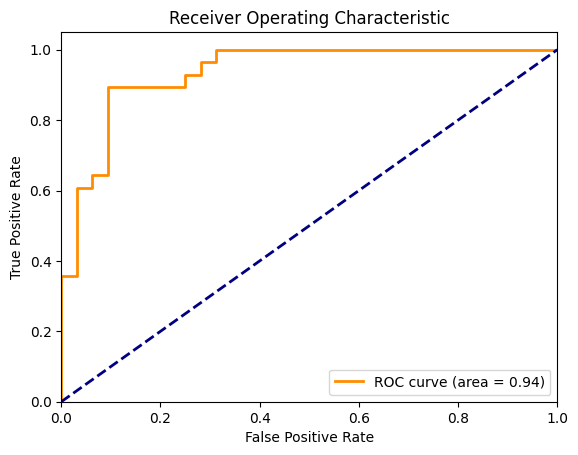

In [5]:
from sklearn.metrics import roc_curve, auc
# 预测概率
y_score = best_model.predict_proba(X_test)[:, 1]

# 计算ROC曲线
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_score)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr_logistic, tpr_logistic, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_logistic)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [6]:
y_score 

array([0.04463077, 0.11498411, 0.3317523 , 0.74676627, 0.24289495,
       0.03970991, 0.7483868 , 0.09146059, 0.35158047, 0.20166625,
       0.77945143, 0.08630815, 0.6588064 , 0.6326487 , 0.898076  ,
       0.54266983, 0.86198723, 0.30403015, 0.96525306, 0.9401338 ,
       0.04191676, 0.09409048, 0.94867903, 0.05066604, 0.9459657 ,
       0.3288474 , 0.06263646, 0.24231808, 0.30340722, 0.81621754,
       0.12077019, 0.42552692, 0.18555334, 0.0500438 , 0.06747115,
       0.52576077, 0.0490279 , 0.55628663, 0.047628  , 0.92454576,
       0.05826542, 0.9789419 , 0.8249449 , 0.89913684, 0.08423168,
       0.11064979, 0.95495   , 0.28179377, 0.26669636, 0.8748676 ,
       0.07327702, 0.7816577 , 0.04527365, 0.04305303, 0.5537553 ,
       0.93692875, 0.7495201 , 0.16172078, 0.11465722, 0.7348623 ],
      dtype=float32)

In [7]:
import shap
explainer = shap.TreeExplainer(best_model)
shap_values_test = explainer.shap_values(X_test)
# 绘制单个样本的SHAP解释（Force Plot）
sample_index = 0  # 选择一个样本索引进行解释
shap.force_plot(explainer.expected_value, shap_values_test[sample_index], X_test.iloc[sample_index], matplotlib=True, show=False)
plt.savefig("SHAP力图.pdf", format='pdf', bbox_inches='tight')

In [8]:
sample = X_test.iloc[sample_index]
# 获取模型对该样本类别1的预测概率
predicted_proba = best_model.predict_proba([sample])[0][1]
predicted_proba

0.044630766

In [9]:
X_test

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
290,41,1,2,120,157,0,0,182,0,0.0,1,0,0
239,49,0,4,130,269,0,0,163,0,0.0,1,0,0
89,66,1,4,120,302,0,2,151,0,0.4,2,0,0
101,57,0,4,128,303,0,2,159,0,0.0,1,1,0
67,54,1,3,150,232,0,2,165,0,1.6,1,0,2
252,42,0,3,120,209,0,0,173,0,0.0,2,0,0
23,58,1,3,132,224,0,2,173,0,3.2,1,2,2
235,49,0,2,134,271,0,0,162,0,0.0,2,0,0
66,60,1,3,140,185,0,2,155,0,3.0,2,0,0
197,50,0,4,110,254,0,2,159,0,0.0,1,0,0


In [10]:
# 加载模型
model = joblib.load('XGBoost.pkl')

# 准备特征数据
# 将特征数据转换为DataFrame，这样更容易与SHAP解释器进行对接
# 假设特征列名为：['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
features = pd.DataFrame([[55, 1, 4, 124, 266, 0, 2, 109, 1, 2.2, 2, 1, 2]], 
                        columns=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal'])

# 创建SHAP解释器
explainer = shap.TreeExplainer(model)

# 计算SHAP值
shap_values = explainer.shap_values(features)

# 绘制单个样本的SHAP解释（Force Plot）
shap.force_plot(explainer.expected_value, shap_values[0], features.iloc[0], matplotlib=True, show=False)

# 保存力图为PDF
plt.savefig("SHAP_force_plot.pdf", format='pdf', bbox_inches='tight')

In [11]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,1,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,2,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,57,0,4,140,241,0,0,123,1,0.2,2,0,2,1
293,45,1,1,110,264,0,0,132,0,1.2,2,0,2,1
294,68,1,4,144,193,1,0,141,0,3.4,2,2,2,1
295,57,1,4,130,131,0,0,115,1,1.2,2,1,2,1


In [12]:
import joblib
import numpy as np

# 加载模型
model = joblib.load('XGBoost.pkl')

# 准备特征数据
# 注意，特征数据应该以与训练时相同的顺序输入
# 以下是您提供的特征值：
# [age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal]
features = np.array([[55, 1, 4, 124, 266, 0, 2, 109, 1, 2.2, 2, 1, 2]])

# 预测类别
predicted_class = model.predict(features)

# 预测概率
predicted_proba = model.predict_proba(features)

# 输出结果
print("Predicted Class:", predicted_class[0])
print("Prediction Probabilities:", predicted_proba[0])

Predicted Class: 1
Prediction Probabilities: [0.03285438 0.9671456 ]
